# Work done by 2nd year student (SISY) at l'Ecole Polytechnique de Tunisie : **JAADARI Fadi**

# Notebook Content
* **Importation**
* **EDA**
* **Dimensionality reduction techniques** 

1. *PCA*
2. *Factor Analysis*
3. *Manifold Learning*


* **Clustering Techniques to identify groups of stocks that exhibit similar behaviour**
1. *Gaussian Mixture Models*
1. *K-means*

* **Evaluation**
* **Conclusion**

# Importing

In [1]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:

import yfinance as yf
from numpy.linalg import eigh
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans


pd.set_option('display.max_rows', None)

In [3]:


# Download the list of S&P 500 tickers from Wikipedia
sp500_url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
sp500_table = pd.read_html(sp500_url)[0]
sp500_tickers = sp500_table['Symbol'].tolist()

# Define the start and end dates for the data
start_date = '2016-01-01'
end_date = '2022-12-31'

#download prices data
data = yf.download(sp500_tickers, start=start_date, end=end_date)


[*********************100%***********************]  503 of 503 completed

2 Failed downloads:
- BF.B: No data found for this date range, symbol may be delisted
- BRK.B: No timezone found, symbol may be delisted


In [5]:

# Keep only the 'Close' prices for each stock
prices = data['Close']

# Calculate daily returns for each stock
stock_data = prices.pct_change()

# Exploratory Data Analysis

*    Plotting stocks with null values 

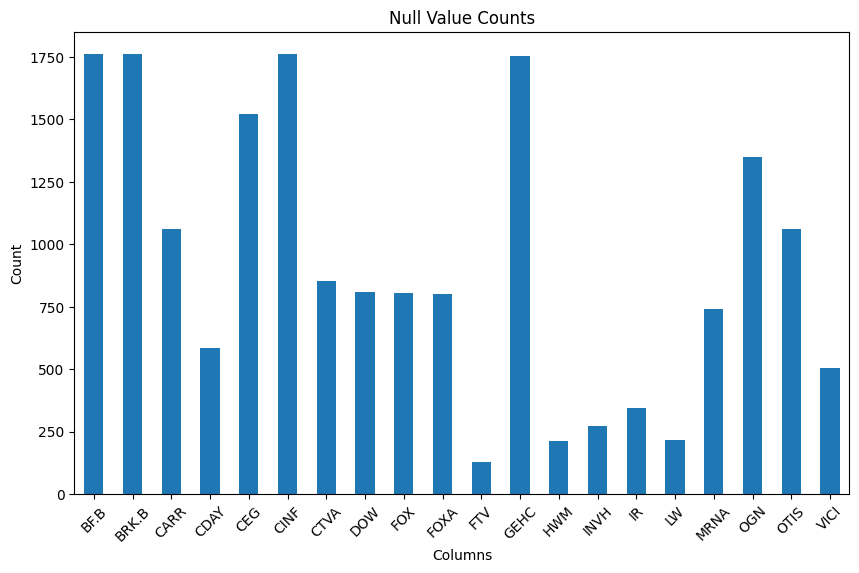

In [ ]:

null_counts = stock_data.isnull().sum()[stock_data.isnull().sum()>100]

# Plotting the null value counts
plt.figure(figsize=(10, 6))
null_counts.plot(kind='bar')
plt.title('Null Value Counts')
plt.xlabel('Columns')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [ ]:
stock_data.head()

,2016-01-05,2016-01-06,2016-01-07,2016-01-08,2016-01-11,2016-01-12,2016-01-13,2016-01-14,2016-01-15,2016-01-19,...,2022-12-16,2022-12-19,2022-12-20,2022-12-21,2022-12-22,2022-12-23,2022-12-27,2022-12-28,2022-12-29,2022-12-30
A,-0.003441,0.004439,-0.042475,-0.010513,-0.016844,0.006589,-0.034826,0.020347,-0.013294,0.002425,...,-0.010341,-0.015740,0.006669,0.014602,-0.007196,0.001476,0.002144,-0.009763,0.020258,-0.009531
AAL,-0.009533,0.017522,-0.018918,-0.001978,0.017587,0.022395,-0.045238,0.011222,-0.044143,0.002580,...,-0.009281,-0.025761,0.004006,0.039904,-0.036071,0.011943,-0.014162,-0.016760,0.030844,0.001575
AAP,-0.006831,-0.026455,0.011073,-0.021971,0.010236,0.006936,-0.039914,-0.005909,0.021016,0.002287,...,-0.021434,0.005280,-0.010788,0.020878,-0.001476,0.008446,0.012144,0.001931,0.006951,0.004921
AAPL,-0.025059,-0.019570,-0.042205,0.005288,0.016192,0.014513,-0.025710,0.021871,-0.024015,-0.004839,...,-0.014579,-0.015910,-0.000529,0.023809,-0.023773,-0.002798,-0.013878,-0.030685,0.028324,0.002469
ABBV,-0.004166,0.000174,-0.002963,-0.027268,-0.031806,0.017817,-0.066740,0.066041,0.050953,-0.040984,...,-0.016064,0.006294,-0.005635,0.010151,0.006535,-0.001041,-0.000674,-0.004663,0.002034,-0.005844


# Preprocessing


*   **Dropping stocks with more than 100 null values**
*   **Changing the type of index from object to datetime**
*   **Dropping duplicates**


In [6]:
def preprocess(df):
    to_drop=[]
    for col in df.columns :
        if(df[col].isnull().sum()>100):
            to_drop.append(col)
    df=df.drop(columns=to_drop)
    
    df.index = pd.to_datetime(df.index) 
    df.index = df.index.date
    date_to_drop = pd.to_datetime('2016-01-04')
    df = df.drop(date_to_drop)
    
    df.drop_duplicates(inplace=True)  
    df = df.transpose()
    return df

stock_data=preprocess(stock_data)

In [ ]:
print(stock_data.shape)  # Check dimensions
print(stock_data.columns)  # Check column names

(483, 1761)
Index([2016-01-05, 2016-01-06, 2016-01-07, 2016-01-08, 2016-01-11, 2016-01-12,
       2016-01-13, 2016-01-14, 2016-01-15, 2016-01-19,
       ...
       2022-12-16, 2022-12-19, 2022-12-20, 2022-12-21, 2022-12-22, 2022-12-23,
       2022-12-27, 2022-12-28, 2022-12-29, 2022-12-30],
      dtype='object', length=1761)


# Dimensionality reduction techniques : PCA || Linear Discriminant Analysis LDA || Manifold Learning(t-SNE)

In [ ]:
stock_data.shape

(483, 1761)

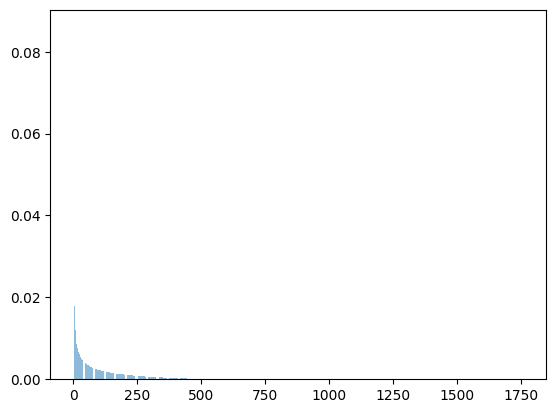

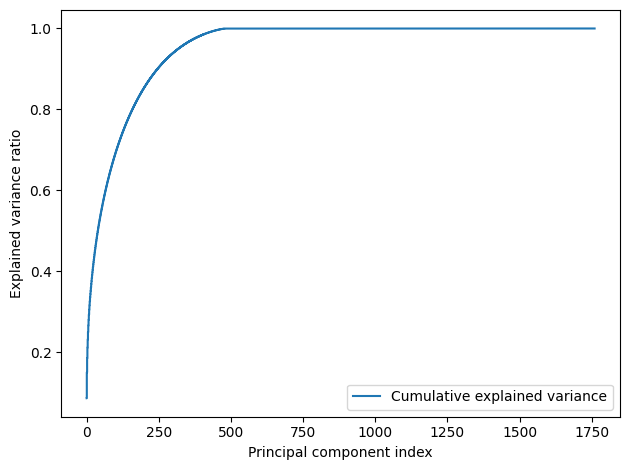

In [9]:

# Scaling the dataset; This is very important before applying PCA
#
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(stock_data)
X_train_std = sc.transform(stock_data)


# covariance matrix
#
cov_matrix = np.cov(X_train_std, rowvar=False)
#
# Determining eigenvalues and eigenvectors
#
egnvalues, egnvectors = eigh(cov_matrix)
#
# Determining explained variance
#
total_egnvalues = sum(egnvalues)
var_exp = [(i/total_egnvalues) for i in sorted(egnvalues, reverse=True)]

cum_sum_exp = np.cumsum(var_exp)
plt.bar(range(0,len(var_exp)), var_exp, alpha=0.5, align='center', label='Individual explained variance')
plt.show()
plt.step(range(0,len(cum_sum_exp)), cum_sum_exp, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

# Interpreting the number of components

In [ ]:
n_components_to_exceed_50_percent = np.argmax(cum_sum_exp >= 0.50) + 1
n_components_to_exceed_80_percent = np.argmax(cum_sum_exp >= 0.80) + 1
n_components_to_exceed_90_percent = np.argmax(cum_sum_exp >= 0.90) + 1
print("number of components needed to exceed a ratio of 50% explained variance : ",n_components_to_exceed_50_percent)
print("number of components needed to exceed a ratio of 80% explained variance : ",n_components_to_exceed_80_percent)
print("number of components needed to exceed a ratio of 90% explained variance : ",n_components_to_exceed_90_percent)

number of components needed to exceed a ratio of 50% explained variance :  40
number of components needed to exceed a ratio of 80% explained variance :  160
number of components needed to exceed a ratio of 90% explained variance :  246


**Out of 1761 features(dates) we only need about 300 principal component to fully explain the variability in the data , this means that there's trends in the dataset and some features are correlated.**

In [10]:
stock_prices = stock_data.values 
sc = StandardScaler()
sc.fit(stock_prices)
stock_prices_std = sc.transform(stock_prices)

**Applying PCA, FactorAnalysis and t-SNE through sklearn library.**

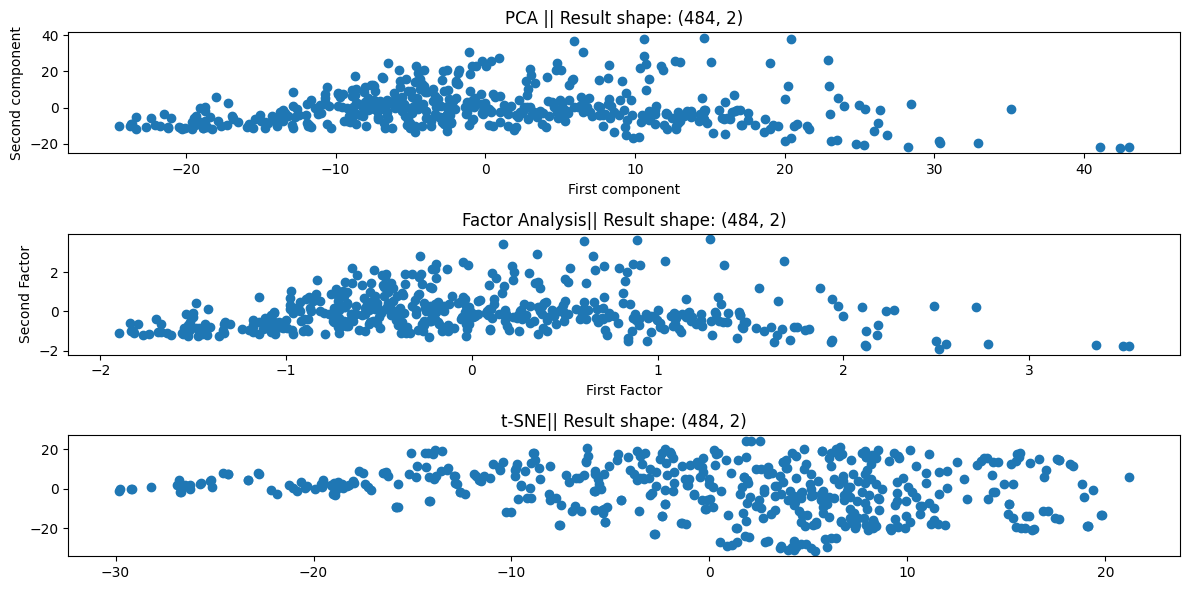

In [11]:
import pandas as pd
from sklearn.decomposition import FactorAnalysis,PCA
from sklearn.manifold import TSNE



#Principal component analysis

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(stock_prices_std)

#Factor Analysis
factor_analysis = FactorAnalysis(n_components=2)
factor_analysis_result = factor_analysis.fit_transform(stock_prices)

# Manifold Learning (t-SNE)
tsne = TSNE(n_components=2)
tsne_result = tsne.fit_transform(stock_prices)

# Visualization  using scatter plots
plt.figure(figsize=(12, 6))

plt.subplot(311)
plt.scatter(principalComponents[:, 0], principalComponents[:, 1])
plt.title("PCA "+"|| Result shape: "+str(principalComponents.shape))
plt.xlabel('First component')
plt.ylabel('Second component')

plt.subplot(312)
plt.scatter(factor_analysis_result[:, 0], factor_analysis_result[:, 1])
plt.title("Factor Analysis"+"|| Result shape: "+str(factor_analysis_result.shape))
plt.xlabel('First Factor')
plt.ylabel('Second Factor')


plt.subplot(313)
plt.scatter(tsne_result[:, 0], tsne_result[:, 1])
plt.title('t-SNE'+ "|| Result shape: "+str(tsne_result.shape))

plt.tight_layout()
plt.show()


**The result of dimensionnality reduction using factor analysis and manifold learning isn't really clear and interpretable as there's many features(dates) and it's quite hard to know how certain date affects the value of a certain stock, nevertheless , we can clearly see a scatter of the points represented by the factors , this can help us in terms of clustering.**

# Clustering Techniques : K-means || Gaussian Mixture Models

* **I thought of clustering the principal components out of pca algorithm to reduce complexity and potentially gain some better information on groups of stocks.**
* **And in order to find the best clustering parameters I  used silhouette_score which is a metric used to evaluate the quality of clusters created using clustering algorithms.**

In [19]:
from sklearn.metrics import silhouette_score
pca = PCA(n_coclusteringmponents=300)
principalComponents = pca.fit_transform(stock_prices_std)


# Assuming you have the cluster assignments stored in 'cluster_assignments_kmeans' and 'cluster_assignments_gmm'

#  Gaussian Mixture Models (GMM)
best_gmm=0
best_kmeans=0
best_nb_components_kmeans=0
best_nb_components_gmm=0
best_cluster_assignments_gmm=[]
best_cluster_assignments_kmeans=[]
for k in range(2,21):
  gmm = GaussianMixture(n_components=k) 
  gmm.fit(stock_prices_std)
  cluster_assignments_gmm = gmm.predict(stock_prices_std)

  #  K-means Clustering
  kmeans = KMeans(n_clusters=k)  
  kmeans.fit(stock_prices_std)
  cluster_assignments_kmeans = kmeans.predict(stock_prices_std)

  kmeans_silhouette = silhouette_score(stock_prices_std, cluster_assignments_kmeans)
  gmm_silhouette = silhouette_score(stock_prices_std, cluster_assignments_gmm)
  if(kmeans_silhouette>best_kmeans):
    best_means=kmeans_silhouette
    best_nb_components_kmeans=k
    best_cluster_assignments_kmeans=cluster_assignments_kmeans
  if(gmm_silhouette>best_gmm):
    best_gmm=gmm_silhouette
    best_nb_components_gmm=k
    best_cluster_assignments_gmm=cluster_assignments_gmm


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

In [20]:
stock_data['Cluster_gmm'] = best_cluster_assignments_gmm
stock_data['Cluster_kmeans'] = best_cluster_assignments_kmeans

# Group stocks by cluster
grouped_stocks_gmm = stock_data.groupby('Cluster_gmm')
grouped_stocks_kmeans = stock_data.groupby('Cluster_kmeans')

# Iterate over each group and print the stocks in each cluster
print("Clustering based on GMM :")
print()
for cluster, stocks in grouped_stocks_gmm:
    print(f"Cluster {cluster}:")
    print(stocks.index.tolist())
    print()
print("-"*200)
print("-"*200)
print()
print("Clustering based on Kmeans :")
print()
for cluster, stocks in grouped_stocks_kmeans:
    print(f"Cluster {cluster}:")
    print(stocks.index.tolist())
    print()

Clustering based on GMM :

Cluster 0:
['A', 'AAPL', 'ADBE', 'ADI', 'ADSK', 'AKAM', 'ALGN', 'AMAT', 'AMD', 'AMZN', 'ANET', 'ANSS', 'ATVI', 'AVGO', 'AXON', 'BIO', 'CDNS', 'CPRT', 'CRL', 'CRM', 'CSGP', 'CTLT', 'CZR', 'DHR', 'DXCM', 'EA', 'EBAY', 'ENPH', 'EPAM', 'ETSY', 'EW', 'FFIV', 'FICO', 'FSLR', 'FTNT', 'GNRC', 'GOOG', 'GOOGL', 'IDXX', 'ILMN', 'INCY', 'INTC', 'INTU', 'IQV', 'ISRG', 'KEYS', 'KLAC', 'LRCX', 'MA', 'MCHP', 'MCO', 'META', 'MKTX', 'MPWR', 'MSCI', 'MSFT', 'MTCH', 'MTD', 'MU', 'NFLX', 'NOW', 'NTAP', 'NVDA', 'NXPI', 'ON', 'PAYC', 'PODD', 'PTC', 'PYPL', 'QCOM', 'QRVO', 'REGN', 'RMD', 'RVTY', 'SEDG', 'SNPS', 'SPGI', 'STX', 'SWKS', 'TECH', 'TER', 'TMO', 'TRMB', 'TSLA', 'TTWO', 'TXN', 'TYL', 'VRSN', 'VRTX', 'WDC', 'WST', 'ZBRA']

Cluster 1:
['AAL', 'AAP', 'ABBV', 'ABC', 'ABT', 'ACGL', 'ACN', 'ADM', 'ADP', 'AEE', 'AEP', 'AES', 'AFL', 'AIG', 'AIZ', 'AJG', 'ALB', 'ALK', 'ALL', 'ALLE', 'AMCR', 'AME', 'AMGN', 'AMP', 'AMT', 'AON', 'AOS', 'APA', 'APD', 'APH', 'APTV', 'ARE', 'ATO', 'AVB', 

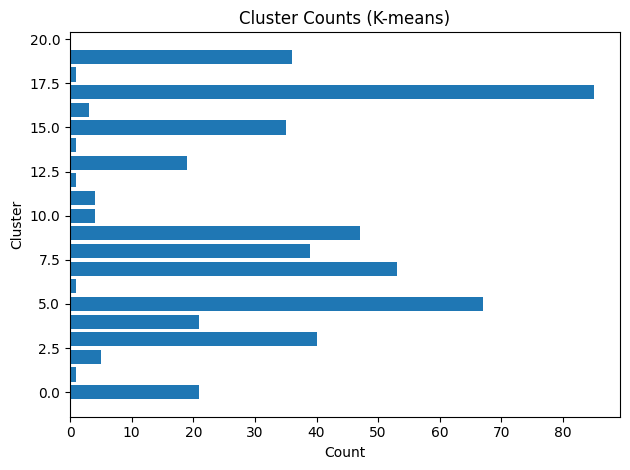

In [21]:
cluster_counts_kmeans = grouped_stocks_kmeans.size()
plt.barh(cluster_counts_kmeans.index, cluster_counts_kmeans.values)
plt.title('Cluster Counts (K-means)')
plt.xlabel('Count')
plt.ylabel('Cluster')
plt.tight_layout()
plt.show()

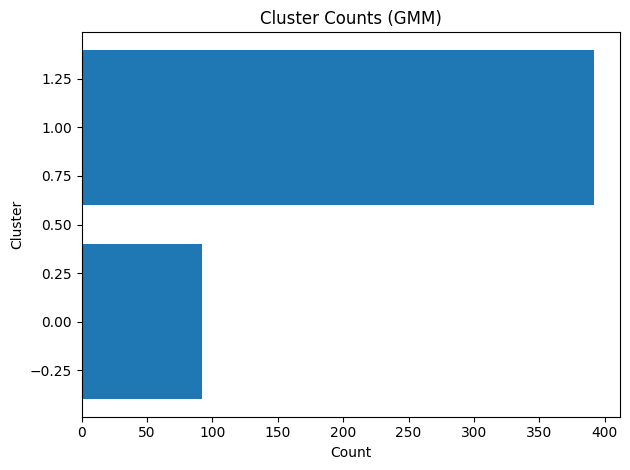

In [22]:
cluster_counts_gmm = grouped_stocks_gmm.size()
plt.barh(cluster_counts_gmm.index, cluster_counts_gmm.values)
plt.title('Cluster Counts (GMM)')
plt.xlabel('Count')
plt.ylabel('Cluster')
plt.tight_layout()
plt.show()

**We can tell that kmeans and gmm are clustering stocks differently but we can't really interpret the resulting clusters unless we execute a profound analysis and find out why each stock is assigned to the designed cluster, but i think that many parameters could affect this behaviour namely : the industry that the company is active in,the country where the activity resides , the type of clients(b2b or b2c) and more.**

# Evaluation

**Silhouette Score**


*   The silhouette score measures the quality of clustering results. It can be used to evaluate both K-means and Gaussian Mixture Models. Higher scores indicate better-defined clusters. 



In [23]:

kmeans_silhouette = silhouette_score(stock_prices_std, best_cluster_assignments_kmeans)
gmm_silhouette = silhouette_score(stock_prices_std, best_cluster_assignments_gmm)

print(f"K-means Silhouette Score: {kmeans_silhouette}")
print(f"GMM Silhouette Score: {gmm_silhouette}")


K-means Silhouette Score: 0.024254226960470485
GMM Silhouette Score: 0.11771755620545983


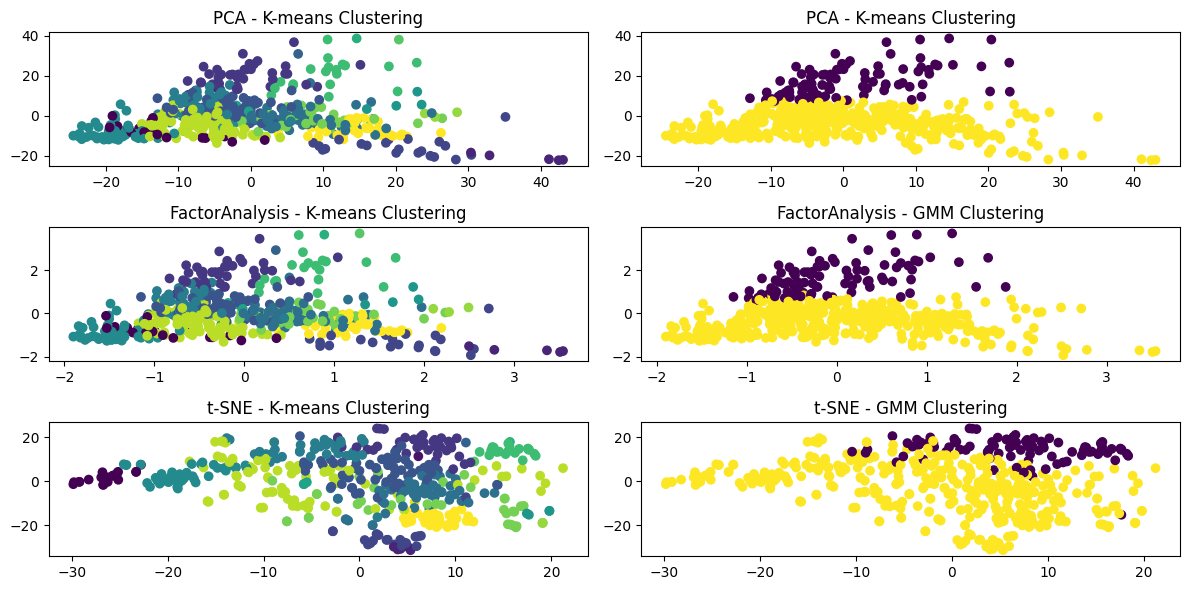

In [24]:

plt.figure(figsize=(12, 6))

# PCA-Kmeans visualization
plt.subplot(3, 2, 1)
plt.scatter(principalComponents[:, 0], principalComponents[:, 1], c=best_cluster_assignments_kmeans)
plt.title("PCA - K-means Clustering")

# PCA-GMM visualization
plt.subplot(3, 2, 2)
plt.scatter(principalComponents[:, 0], principalComponents[:, 1], c=best_cluster_assignments_gmm)
plt.title("PCA - K-means Clustering")

# FactorAnalysis-Kmeans visualization
plt.subplot(3, 2, 3)
plt.scatter(factor_analysis_result[:, 0], factor_analysis_result[:, 1], c=best_cluster_assignments_kmeans)
plt.title("FactorAnalysis - K-means Clustering")

# FactorAnalysis-GMM visualization
plt.subplot(3, 2, 4)
plt.scatter(factor_analysis_result[:, 0], factor_analysis_result[:, 1], c=best_cluster_assignments_gmm)
plt.title("FactorAnalysis - GMM Clustering")


# T-SNE visualization-Kmeans
plt.subplot(3, 2, 5)
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=best_cluster_assignments_kmeans)
plt.title("t-SNE - K-means Clustering")

# T-SNE visualization-GMM
plt.subplot(3, 2, 6)
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=best_cluster_assignments_gmm)
plt.title("t-SNE - GMM Clustering")

plt.tight_layout()
plt.show()


# Conclusion

* **After conducting a comprehensive analysis of the stock data using dimensionality reduction techniques (PCA, Factor Analysis, T-SNE) and clustering techniques (K-means, Gaussian Mixture Models), I have identified several patterns and relationships within the data. However, due to the nature of the dataset being time series, the interpretability of the results was limited.**

* **Through evaluating the performance of the different techniques, I found that both K-means and Gaussian Mixture Models produced clusters with similar silhouette scores, indicating comparable quality of clustering results. However, further validation using cluster validation indices such as the Davies-Bouldin Index and Calinski-Harabasz Index is necessary to determine the most suitable technique.**

* **The visualizations of the clustered data generated by PCA and T-SNE revealed some level of separation among the clusters. While it is challenging to interpret the exact meaning of these clusters solely based on the stock values over time, they could potentially indicate underlying patterns related to factors such as industry sectors, market capitalization, or volatility.**

* **To gain a deeper understanding, I plan to consult with domain experts or financial analysts who can provide insights into whether the identified clusters align with known economic or industry-related factors. Their expertise will help validate the clustering results and potentially uncover additional factors that may explain the observed patterns.**

* **In conclusion, although the interpretability of the clustering results is limited by the time series nature of the dataset, the analysis has provided a foundation for further investigation. By incorporating domain knowledge and exploring external factors such as macroeconomic indicators and industry-specific factors, I aim to unveil the underlying relationships and patterns that can be related to the broader context of the financial markets. This will enable me to draw more meaningful conclusions and potentially identify actionable insights for investment strategies, risk management, or portfolio allocation.**